# Import necessary Python libraries

In [2]:
pip install segyio

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 54.5 MB/s eta 0:00:00:00:0100:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install segysak

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.3/313.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 70.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.7/123.7 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 24.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

In [3]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 13.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install plotly

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 84.1 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 86.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 25.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [91]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.9/83.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 108.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 42.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━

In [4]:
import segyio
from segysak.segy import segy_header_scan
from IPython.display import display

In [5]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as px
import plotly.graph_objects as go
import plotly.express as px
from pylab import figure, cm

In [6]:
from sklearn import metrics
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from itertools import product

In [7]:
import warnings
warnings.filterwarnings('ignore')

import scipy as sp
import re
from IPython.display import display
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Data Import

The following 3D volumes are present in the dataset:
1. Facies
2. Seismic volume
3. Relative Acoustic Impedance (RelAI)
4. Instantaneous Frequency
5. Envelope
6. Seismic Inversion

In [13]:
facies = segyio.tools.cube('/data/Facies_Cube _case_4.segy')
seis = segyio.tools.cube('/data/Seismic_Cube_Ormsby_10_60_case_4.segy')
relai = segyio.tools.cube('/data/RelAcImpedance_10_60_Cube_case_4.segy')
inst_freq = segyio.tools.cube('/data/InstFs_10_60_Cube_case_4.segy')
envel = segyio.tools.cube('/data/Envelope_10_60_Cube_case_4.segy')
seis_inv = segyio.tools.cube('/data/Impedance_10_60_Cube_case_4.segy')


# Exploratory Data Analysis & Visualization

## Cleaning the dataset

The data is equal to -1 outside of the zone of interest. Hence, we will get remove those data points.

In [14]:
facies = np.where(facies==-1, np.nan, facies)
seis = np.where(seis==-1, np.nan, seis)
relai= np.where(relai==-1, np.nan, relai)
inst_freq= np.where(inst_freq==-1, np.nan, inst_freq)
envel = np.where(envel==-1, np.nan, envel)
seis_inv = np.where((seis_inv==-1), np.nan, seis_inv)

Let us inspect the shape of the dataset, to ensure consistency. 

In [15]:
facies.shape

(71, 65, 700)

In [16]:
seis_inv.shape

(71, 65, 701)

We will remove the additional row of the Seismic Inverted volume. 

In [17]:
seis_inv_1 = np.delete(seis_inv, -1, axis=-1)
seis_inv_1.shape

(71, 65, 700)

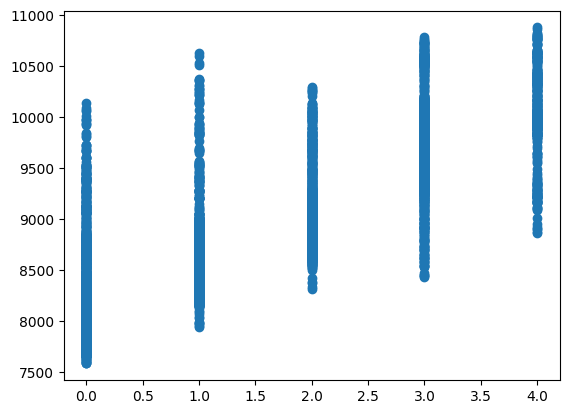

In [18]:
plt.scatter(facies[[0]], seis_inv_1[[0]])

## Plotting 3D cubes

In [19]:
def plot_3D_cube(data, color_map='facies', number_of_facies=5, number_of_wells=7):
    x = np.indices(data.shape)[0]
    y = np.indices(data.shape)[1]
    z = np.indices(data.shape)[2]
    col = data.flatten()

    # 3D Plot
    fig = plt.figure(figsize=(10, 6))
    ax3D = fig.add_subplot(projection='3d')
    # ax3D = plt.axes(projection='3d')



    # We will extract 7 wells for training, such that they don't cross any fault zones.
    start_x = [10, 60, 30, 25, 65, 50, 21]
    start_y = [15, 15, 20, 58, 60, 50, 35]
    start_z = [700, 700, 700, 700, 700, 700, 700]

    end_x = [10, 60, 30, 25, 65, 50, 21]
    end_y = [15, 15, 20, 58, 60, 50, 35]
    end_z  =[0, 0, 0, 0, 0, 0, 0]

    ax3D.set_xlabel('x')
    ax3D.set_ylabel('y')
    ax3D.set_zlabel('z')

    if number_of_wells == 7:
        for well in range(number_of_wells):
            ax3D.plot([start_x[well], end_x[well]], [start_y[well], end_y[well]],  zs=[start_z[well], end_z[well]], color='black', linewidth = 1)

    elif number_of_wells == None:
        pass


    if color_map == 'facies':

        if number_of_facies == 5:
            facies_name = ['','Coarse Sand', 'Sand', 'Fine Sand', 'Shale']
            facies_color = ['#FFFFFF' ,'#E69076', '#FFFF00', '#FFCC00', '#A6A6A6', '#8080FF']
            cmap = matplotlib.colors.ListedColormap(facies_color)
            bounds = [-1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
            norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

            p3d = ax3D.scatter(x, y, z, c=data, cmap=cmap)
            fig.colorbar(p3d)


        if number_of_facies == 4:
            facies_name = ['Coarse Sand', 'Sand', 'Fine Sand', 'Shale']
            facies_color = ['#E69076', '#FFFF00', '#FFCC00', '#A6A6A6', '#8080FF']
            cmap = matplotlib.colors.ListedColormap(facies_color)
            bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
            norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

            p3d = ax3D.scatter(x, y, z, c=data, cmap=cmap)
            fig.colorbar(p3d, ticks=np.arange(0, 5))

    elif color_map == 'relai':

        p3d = ax3D.scatter(x, y, z, c=data, cmap='jet')
        fig.colorbar(p3d)

    else:

        p3d = ax3D.scatter(x, y, z, c=data, cmap='jet')
        fig.colorbar(p3d)

    plt.show()

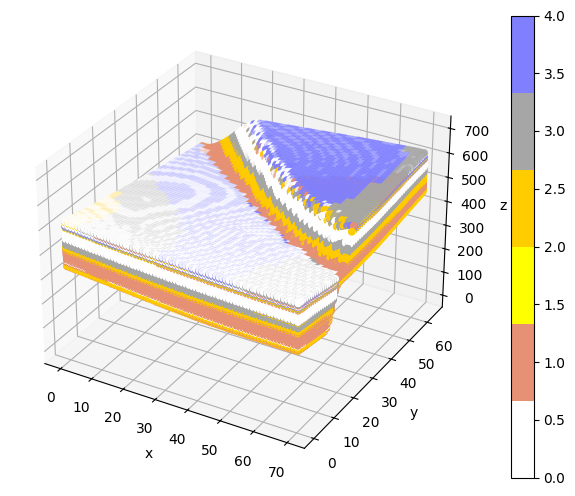

In [20]:
plot_3D_cube(data=facies, color_map='facies', number_of_facies=5, number_of_wells=None)

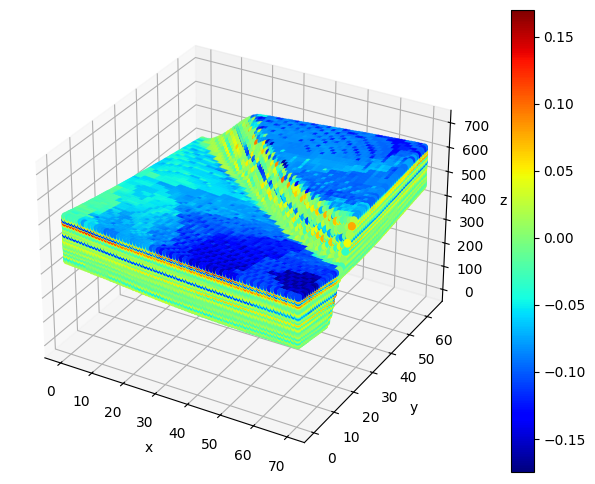

In [21]:
plot_3D_cube(data=seis, color_map='seis', number_of_facies=5, number_of_wells=None)

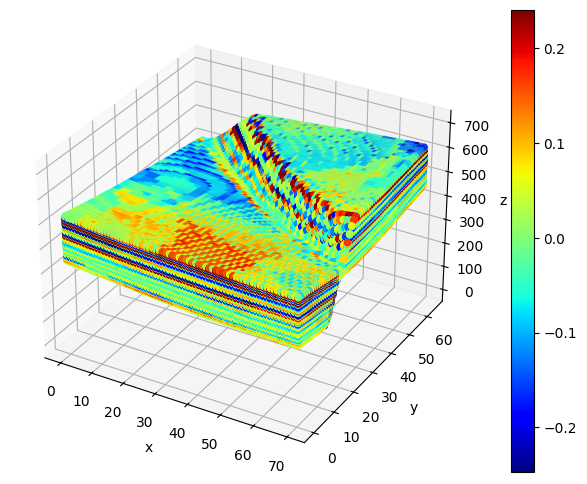

In [22]:
plot_3D_cube(data=relai, color_map='relai', number_of_facies=None, number_of_wells=None)

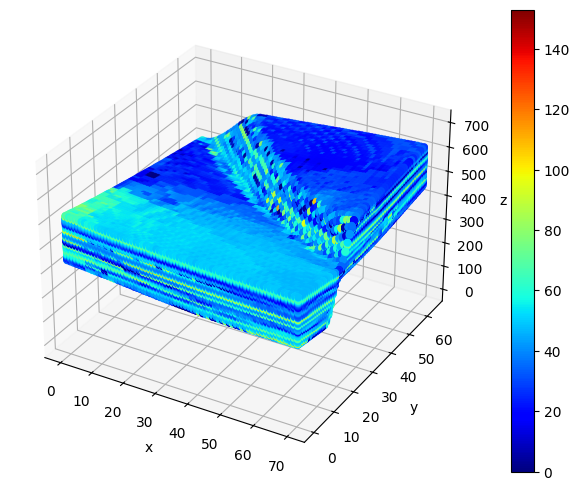

In [23]:
plot_3D_cube(data=inst_freq, color_map='any', number_of_facies=None, number_of_wells=None)

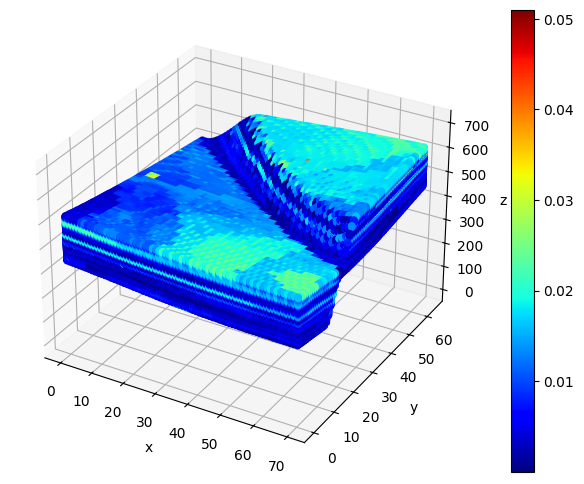

In [24]:
plot_3D_cube(data=envel, color_map='any', number_of_facies=None, number_of_wells=None)

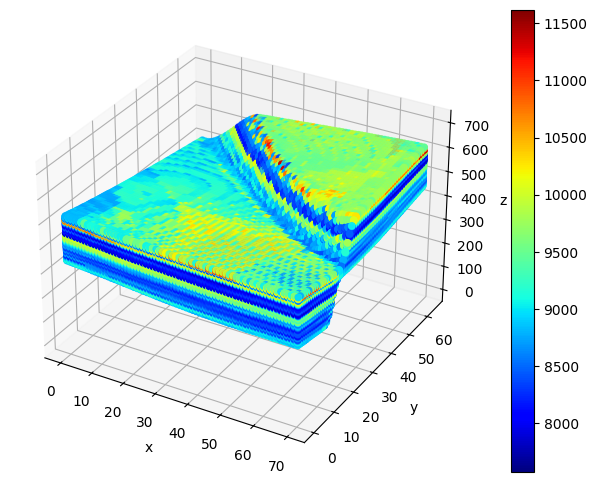

In [25]:
plot_3D_cube(data=seis_inv_1, color_map='any', number_of_facies=None, number_of_wells=None)

## Statistical Analysis

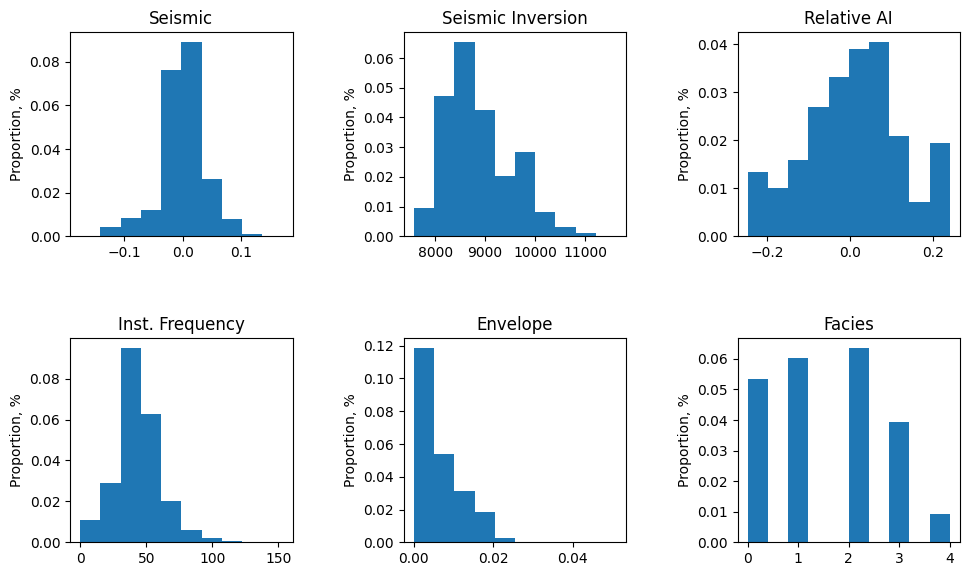

In [26]:
# Histograms
fig, ax = plt.subplots(2, 3, figsize=(10, 6))
# fig, ax = plt.subplots(2, 3)


# Seismic
ax[0, 0].hist(seis.flatten(), weights=np.ones(len(seis.flatten())) / len(seis.flatten()))
ax[0, 0].set_title('Seismic')

# Seismic Inv
ax[0, 1].hist(seis_inv_1.flatten(), weights=np.ones(len(seis_inv_1.flatten())) / len(seis_inv_1.flatten()))
ax[0, 1].set_title('Seismic Inversion')

# Rel AI
ax[0, 2].hist(relai.flatten(), weights=np.ones(len(relai.flatten())) / len(relai.flatten()))
ax[0, 2].set_title('Relative AI')

# Inst Freq
ax[1, 0].hist(inst_freq.flatten(), weights=np.ones(len(inst_freq.flatten())) / len(inst_freq.flatten()))
ax[1, 0].set_title('Inst. Frequency')

# Envelope
ax[1, 1].hist(envel.flatten(), weights=np.ones(len(envel.flatten())) / len(envel.flatten()))
ax[1, 1].set_title('Envelope')
ax.flatten()[4].set_ylabel('Envelope, %')

# # Facies
ax[1, 2].hist(facies.flatten(), weights=np.ones(len(facies.flatten())) / len(facies.flatten()))
ax[1, 2].set_title('Facies')


for i in range(6):
    ax.flatten()[i].set_ylabel('Proportion, %')

fig.subplots_adjust(left=0.1, right=0.99, bottom=0.05, top=0.9,
                    hspace=0.5, wspace=0.5)


plt.show()

# Feature Scaling & Standardization

In [27]:
def standartization_3D(feature_3D_array):

    # Flatten 3D array (to 1D)
    feature_array_1d = feature_3D_array.reshape(-1)

    # Calculate STD
    std_all = np.nanstd(feature_array_1d)

    # Calculate Mean
    mean_all = np.nanmean(feature_array_1d)

    # Apply Standartization
    feature_std_3D = (feature_3D_array - mean_all) / std_all

    return feature_std_3D

In [28]:
relai_std = standartization_3D(relai)
relai_std.shape

(71, 65, 700)

In [29]:
seis_inv_std = standartization_3D(seis_inv_1)
seis_inv_std.shape

(71, 65, 700)

In [30]:
inst_freq_std = standartization_3D(inst_freq)
inst_freq_std.shape

(71, 65, 700)

In [31]:
envel_std = standartization_3D(envel)
envel_std.shape

(71, 65, 700)

In [33]:
seis_std = standartization_3D(seis)
seis_std.shape

(71, 65, 700)

Select 7 wells for training the models, such that the wells don't cross over fault zones.

In [34]:
start_x = [10, 60, 30, 25, 65, 50, 21]
start_y = [15, 15, 20, 58, 60, 50, 35]
start_z = [660, 660, 660, 660, 660, 660, 660]

end_x = [10, 60, 30, 25, 65, 50, 21]
end_y = [15, 15, 20, 58, 60, 50, 35]
end_z  =[0, 0, 0, 0, 0, 0, 0]

Using the well path coordinates, extract the properties for those wells. 

In [35]:
def extract_wells_with_data_3D(data_3D, x_coord_wells, y_coord_wells):
    wells_list = []

    for well_x in x_coord_wells:
        for well_y in y_coord_wells:

            each_well = data_3D[x_coord_wells, y_coord_wells, :]

    wells_list.append(each_well)

    # Convert to list and Remove nan from well_all
    well_3d_array = np.asarray(wells_list)
    well_2d_array = np.reshape(well_3d_array, (len(x_coord_wells), data_3D.shape[2]))
    # wells_1d_array = well_2d_array.flatten()

    return well_2d_array

In [36]:
seis_inv_std_wells = extract_wells_with_data_3D(seis_inv_std, start_x, start_y)
seis_inv_std_wells

df_seis_inv_std_wells = pd.DataFrame(seis_inv_std_wells.T)



In [37]:
relai_std_wells = extract_wells_with_data_3D(relai_std, start_x, start_y)
relai_std_wells
df_relai_std_wells = pd.DataFrame(relai_std_wells.T)


In [38]:
seis_std_wells = extract_wells_with_data_3D(seis_std, start_x, start_y)
seis_std_wells
df_seis_std_wells = pd.DataFrame(seis_std_wells.T)


In [39]:
inst_freq_std_wells = extract_wells_with_data_3D(inst_freq_std, start_x, start_y)
inst_freq_std_wells
df_inst_freq_std_wells = pd.DataFrame(inst_freq_std_wells.T)


In [40]:
envel_std_wells = extract_wells_with_data_3D(envel_std, start_x, start_y)
envel_std_wells
df_envel_std_wells = pd.DataFrame(envel_std_wells.T)


In [41]:
facies_wells = extract_wells_with_data_3D(facies, start_x, start_y)
facies_wells
df_facies_wells = pd.DataFrame(facies_wells.T)


In [42]:
np.unique(facies_wells)

array([ 0.,  1.,  2.,  3.,  4., nan], dtype=float32)

In [43]:
print(relai_std_wells.shape)
print(seis_inv_std_wells.shape)
print(seis_std_wells.shape)
print(envel_std_wells.shape)
print(inst_freq_std_wells.shape)

(7, 700)
(7, 700)
(7, 700)
(7, 700)
(7, 700)


Create a list with the required properties

In [44]:
feature_list_RelAI_Seis_Envel_InstFreq_SeisInv =    [df_relai_std_wells,
                                                    df_seis_std_wells,
                                                    df_envel_std_wells,
                                                    df_inst_freq_std_wells,
                                                    df_seis_inv_std_wells
                                                    ]
len(feature_list_RelAI_Seis_Envel_InstFreq_SeisInv)

5

In [60]:
def difference_map_3D(df_facies_comparison, facies_predicted, number_of_wells=7):
    d, e, f = np.shape(df_facies_comparison)
    facies_difference_map = np.zeros((d, e, f))
    facies_difference_map[:] = np.NaN


    # The difference map
    np_facies_fact = df_facies_comparison
    np_facies_predicted = facies_predicted


    facies_difference = np.subtract(np_facies_fact, np_facies_predicted)
    # np.unique(facies_difference)
    facies_difference_map = np.where(((facies_difference >= 1) | (facies_difference <= -1)),  1, facies_difference)


    x = np.indices(df_facies_comparison.shape)[0]
    y = np.indices(df_facies_comparison.shape)[1]
    z = np.indices(df_facies_comparison.shape)[2]
    col = df_facies_comparison.flatten()

    # 3D Plot
    fig = plt.figure(figsize=(8, 8))
    #fig1=plt.figure(figsize=(8,5))
    ax3D = fig.add_subplot(projection='3d')



    start_x = [10, 60, 30, 25, 65, 50, 21]
    start_y = [15, 15, 20, 58, 60, 50, 35]
    start_z = [700, 700, 700, 700, 700, 700, 700]

    end_x = [10, 60, 30, 25, 65, 50, 21]
    end_y = [15, 15, 20, 58, 60, 50, 35]
    end_z  =[0, 0, 0, 0, 0, 0, 0]

    ax3D.set_xlabel('x')
    ax3D.set_ylabel('y')
    ax3D.set_zlabel('z')

    for well in range(number_of_wells):
        ax3D.plot([start_x[well], end_x[well]], [start_y[well], end_y[well]],  zs=[start_z[well], end_z[well]], color='black', linewidth = 1)


    cmap = matplotlib.colors.ListedColormap(['green', 'red'])
    bounds = [-0.5, 0.5, 1.5]
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    p3d = ax3D.scatter(x, y, z, c=facies_difference_map, cmap=cmap)
    # fig.colorbar(p3d, ticks=np.arange(0, 5))
    fig.colorbar(p3d, ticks=np.arange(0, 2))
    plt.show()

# Supervised ML models

## Data Preparation

In [45]:
def concat_features_RelAI_Seis_Envel_InstFreq_SeisInv(df_facies_wells, feature_list_RelAI_Seis_Envel_InstFreq_SeisInv):
    """The function concatenate features (RelAI, Seismic, Envelope, InstFreq) with Facies

    Args:
        df_facies_wells (DataFrame): Facies
        feature_list_RelAI_Seis_Envel_InstFreq (lisr): list of features

    Returns:
        facies_and_features (DataFrame): concatenated dataframe with facies and 5 features (Relative AI,
        Seismic, Envelope, Instant Frequency, Geological Time)
    """
    def create_empty_lists(a):
        for i in range(a):
            yield []

    XX0, XX1, XX2, XX3, XX4 = create_empty_lists(len(feature_list_RelAI_Seis_Envel_InstFreq_SeisInv))
    YY1 = []

    for every_well in range(len(df_facies_wells.columns)):

        X0 = feature_list_RelAI_Seis_Envel_InstFreq_SeisInv[0].iloc[:,every_well]
        X1 = feature_list_RelAI_Seis_Envel_InstFreq_SeisInv[1].iloc[:,every_well]
        X2 = feature_list_RelAI_Seis_Envel_InstFreq_SeisInv[2].iloc[:,every_well]
        X3 = feature_list_RelAI_Seis_Envel_InstFreq_SeisInv[3].iloc[:,every_well]
        X4 = feature_list_RelAI_Seis_Envel_InstFreq_SeisInv[4].iloc[:,every_well]

        Y = df_facies_wells.iloc[:,every_well]

        XX0.append(X0)
        XX1.append(X1)
        XX2.append(X2)
        XX3.append(X3)
        XX4.append(X4)

        YY1.append(Y)

    XX0 = pd.concat(XX0, ignore_index=False, axis=0)
    XX1 = pd.concat(XX1, ignore_index=False, axis=0)
    XX2 = pd.concat(XX2, ignore_index=False, axis=0)
    XX3 = pd.concat(XX3, ignore_index=False, axis=0)
    XX4 = pd.concat(XX4, ignore_index=False, axis=0)

    facies = pd.concat(YY1, ignore_index=False)

    features = pd.concat([XX0, XX1, XX2, XX3, XX4], axis=1)

    features = features.rename(columns = {0:'relai',
                                          1:'seis',
                                          2: 'envel',
                                          3: 'inst_freq',
                                          4: 'seis_inv'
                                          })
    features

    facies = pd.DataFrame(facies).rename(columns={0:'facies'})
    facies

    facies_and_features = pd.concat([facies, features], axis=1)
    facies_and_features = facies_and_features.dropna(axis=0)

    return facies_and_features

In [46]:
facies_features_3 = concat_features_RelAI_Seis_Envel_InstFreq_SeisInv(df_facies_wells, feature_list_RelAI_Seis_Envel_InstFreq_SeisInv)
facies_features_3

facies_and_features = facies_features_3.copy()
facies_and_features


,facies,relai,seis,envel,inst_freq,seis_inv
296,2.0,0.706338,0.576049,-0.236991,-0.573114,0.375190
297,2.0,0.819881,0.403899,-0.283861,-0.635736,0.427023
298,2.0,0.884136,0.243593,-0.325186,-0.685833,0.473044
299,2.0,0.903801,0.095923,-0.355929,-0.700594,0.514216
300,2.0,0.879689,-0.050958,-0.387175,-0.676887,0.547856
...,...,...,...,...,...,...
422,1.0,0.535116,-1.042009,1.123232,-1.683755,1.262439
423,4.0,0.325316,-1.338140,1.062755,-1.233773,1.170338
424,4.0,0.019821,-1.648485,1.141375,-0.927821,1.030158
425,4.0,-0.372161,-1.921715,1.282488,-0.773951,0.830202


In [47]:
facies_and_features['facies'].value_counts()

facies
2.0    357
1.0    324
0.0    290
3.0    214
4.0     60
Name: count, dtype: int64

In [48]:
x_train, x_test, y_train, y_test = train_test_split(facies_and_features[['relai','seis', 'envel', 'inst_freq', 'seis_inv']],
                                                    facies_and_features[['facies']],
                                                    train_size=0.8,
                                                    random_state=123)

In [49]:
y_train.describe()

,facies
count,996.000000
mean,1.550201
std,1.165022
min,0.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,4.000000


## Logistic Regression

In [50]:
model_LR = LogisticRegression()
model_LR.fit(x_train, y_train)

LogisticRegression()

In [51]:
test_predict = model_LR.predict(x_test)

print(pd.crosstab(y_test.values.flatten(), test_predict))
print(classification_report(y_test.values.flatten(), test_predict))

col_0  0.0  1.0  2.0  3.0  4.0
row_0                         
0.0     56    3    0    0    3
1.0      3   49    2    3    1
2.0      2   15   59    2    1
3.0      2    0    9   29    0
4.0      0    0    0    5    5
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.90        62
         1.0       0.73      0.84      0.78        58
         2.0       0.84      0.75      0.79        79
         3.0       0.74      0.72      0.73        40
         4.0       0.50      0.50      0.50        10

    accuracy                           0.80       249
   macro avg       0.74      0.74      0.74       249
weighted avg       0.80      0.80      0.79       249



In [52]:
def accuracy_score_cv(estimator, X, y, cv=10):

    from sklearn.model_selection import cross_val_score
    #Applying 10-fold cross validation
    accuracy_score_cv = cross_val_score(estimator=estimator, X=X, y=y, cv=cv)
    print("accuracy: ", np.mean(accuracy_score_cv))

    return np.mean(accuracy_score_cv)
accuracy_score_LR = accuracy_score_cv(estimator=model_LR, X=x_train, y=y_train, cv=10)
accuracy_score_LR

accuracy:  0.7872525252525253


0.7872525252525253

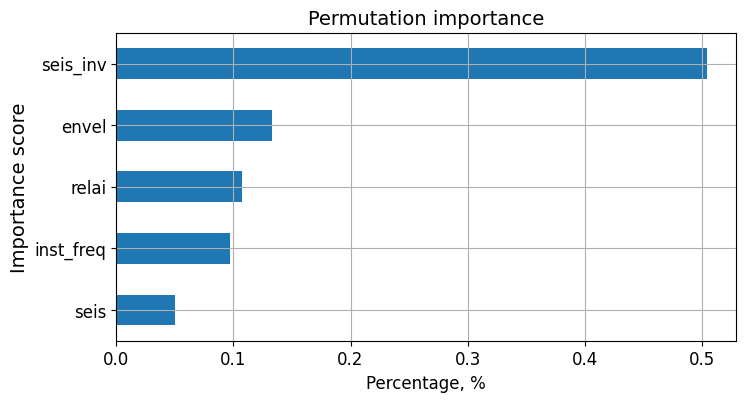

In [53]:
def feature_importance_plot(model, x_train, y_train, random_state):

    from sklearn.inspection import permutation_importance

    res = permutation_importance(model, x_train, y_train, scoring='accuracy', random_state=random_state)
    importance = res.importances_mean
    importance
    importance_res = pd.Series(importance, index=x_train.columns).sort_values(ascending=True)
    importance_res
    # Plot the results
    fig, ax = plt.subplots(figsize=(8,4))
    ax = importance_res.plot.barh()
    ax.set_title('Permutation importance', fontsize=14)
    ax.set_ylabel('Importance score', fontsize=14)
    ax.set_xlabel('Percentage, %', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid()
    plt.show()
feature_importance_plot(model_LR, x_train, y_train, random_state=50)

In [54]:
def predict_facies_3D(facies, relai_std, seis_std, envel_std, inst_freq_std, seis_inv_std, model):
    r, c, b = np.shape(facies)

    map_facies = np.zeros((r, c, b))
    map_facies[:] = np.NaN
    map_facies_1 = map_facies.copy()
    df_f_comparison = map_facies.copy()

    # for every trace (column)
    for every_x in range(facies.shape[0]):
        for every_y in range(facies.shape[1]):

            new_df = pd.concat(
                        [pd.DataFrame(relai_std[every_x, every_y]),
                        pd.DataFrame(seis_std[every_x, every_y]),
                        pd.DataFrame(envel_std[every_x, every_y]),
                        pd.DataFrame(inst_freq_std[every_x, every_y]),
                        pd.DataFrame(seis_inv_std[every_x, every_y])]
                        , axis=1)



            new_features = new_df.dropna(axis=0)

            #new_features = new_df
            non_empty_facies = pd.DataFrame(facies[every_x, every_y, :]).dropna(axis=0)

            map_facies[every_x, every_y, new_features.index] = model.predict(new_features)


            # Filter
            map_facies_1[every_x, every_y, non_empty_facies.index] = map_facies[every_x, every_y, non_empty_facies.index]
            df_f_comparison[every_x, every_y, new_features.index] = facies[every_x, every_y, new_features.index]

    # df_facies_wells = df_wells_from_section(df_f_copy, col_30)

    map_facies
    map_facies_1
    return map_facies_1, df_f_comparison

In [55]:
facies_pred, df_facies_comparison = predict_facies_3D(facies=facies,

                                                    relai_std=relai_std,
                                                    seis_std=seis_std,
                                                    envel_std=envel_std,
                                                    inst_freq_std=inst_freq_std,
                                                    seis_inv_std=seis_inv_std,

                                                    model=model_LR)


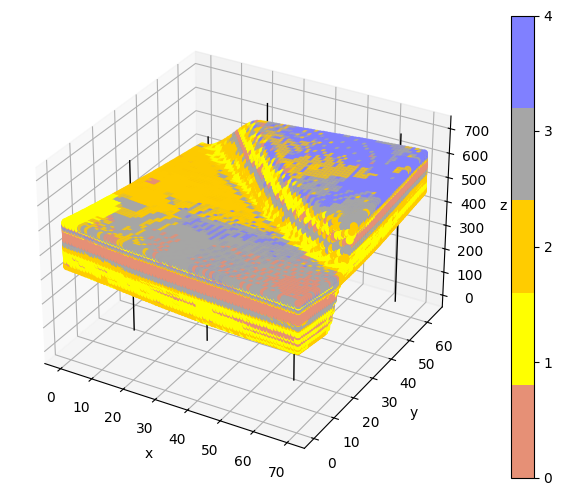

In [56]:
plot_3D_cube(data=facies_pred, color_map='facies', number_of_facies=4, number_of_wells=7)

              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85    173009
         1.0       0.69      0.76      0.72    195124
         2.0       0.73      0.67      0.70    205246
         3.0       0.74      0.77      0.75    127077
         4.0       0.67      0.44      0.53     29677

    accuracy                           0.75    730133
   macro avg       0.74      0.70      0.71    730133
weighted avg       0.75      0.75      0.74    730133



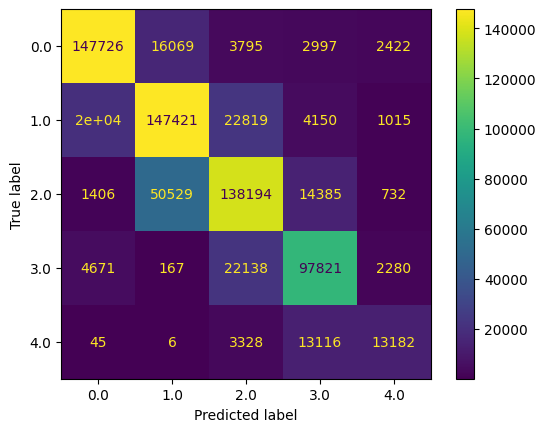

In [57]:
def confusion_matrix_3D(facies_pred, df_facies_comparison, model):

    from sklearn.metrics import f1_score
    from sklearn.metrics import precision_recall_fscore_support
    from sklearn import metrics
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
    from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay

    actual_f = df_facies_comparison[~(np.isnan(df_facies_comparison))]
    predicted_f = facies_pred[~(np.isnan(facies_pred))]

    conf_matrix = metrics.confusion_matrix(actual_f, predicted_f)
    conf_matrix

    f1_score_per_class = f1_score(actual_f, predicted_f, average=None)
    accuracy_estimation = accuracy_score(actual_f, predicted_f)

    report_print = print(classification_report(actual_f, predicted_f))

    # Extract number of values of each class
    count_facies = np.unique(actual_f, return_counts=True)[1]

    # Plot confusion matrix
    display_conf_matrix = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
    display_conf_matrix.plot()
    plt.show()

    return report_print, f1_score_per_class, count_facies, accuracy_estimation
report_print_LR, f1_score_per_class_LR, count_facies, accuracy_test_LR = confusion_matrix_3D(facies_pred,
                                                                                                df_facies_comparison,
                                                                                                model_LR)

In [58]:
accuracy_test_LR

0.745540880907999

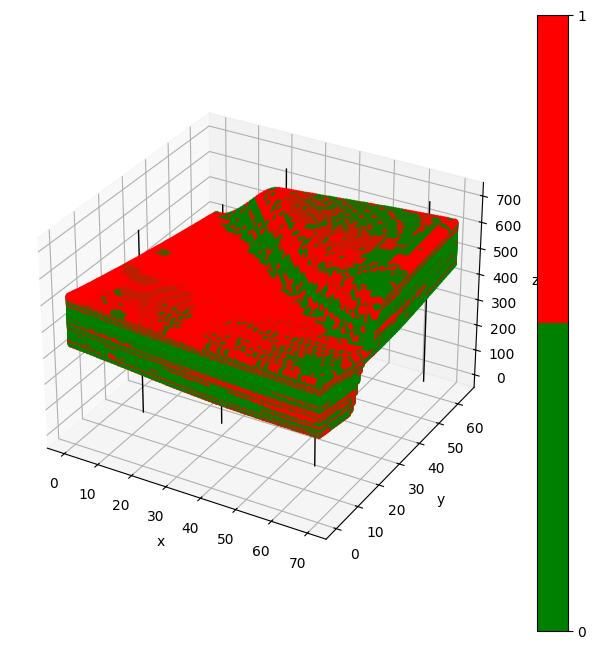

In [62]:
difference_map_3D(df_facies_comparison, facies_pred, number_of_wells=7)

## Random Forest classification

In [70]:
RF_Classifier_model = RandomForestClassifier(class_weight='balanced').fit(x_train, y_train)

In [71]:
facies_predict_RF = RF_Classifier_model.predict(x_test)

In [72]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test, facies_predict_RF))
print(accuracy_score(y_test, facies_predict_RF))
print(classification_report(y_test, facies_predict_RF))

[[57  2  0  0  3]
 [ 4 47  5  0  2]
 [ 1  6 69  3  0]
 [ 0  0  3 36  1]
 [ 0  0  3  2  5]]
0.8594377510040161
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92        62
         1.0       0.85      0.81      0.83        58
         2.0       0.86      0.87      0.87        79
         3.0       0.88      0.90      0.89        40
         4.0       0.45      0.50      0.48        10

    accuracy                           0.86       249
   macro avg       0.79      0.80      0.80       249
weighted avg       0.86      0.86      0.86       249



In [73]:
accuracy_score_RF = accuracy_score_cv(estimator=RF_Classifier_model, X=x_train, y=y_train, cv=10)
accuracy_score_RF

accuracy:  0.8806262626262626


0.8806262626262626

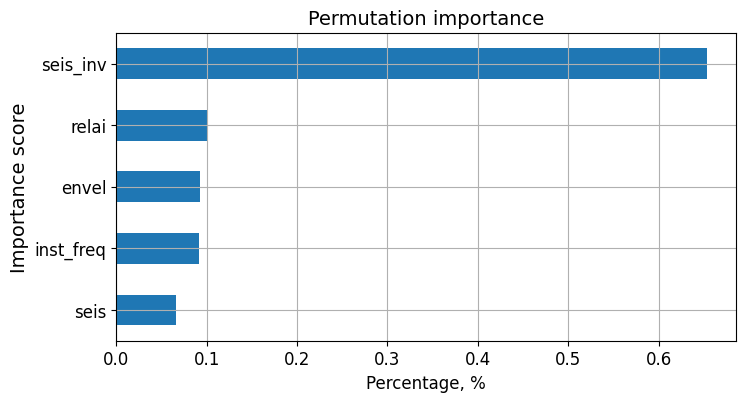

In [74]:
feature_importance_plot(RF_Classifier_model, x_train, y_train, random_state=50)

In [75]:
facies_pred, df_facies_comparison = predict_facies_3D(facies=facies,

                                                    relai_std=relai_std,
                                                    seis_std=seis_std,
                                                    envel_std=envel_std,
                                                    inst_freq_std=inst_freq_std,
                                                    seis_inv_std=seis_inv_std,

                                                    model=RF_Classifier_model)

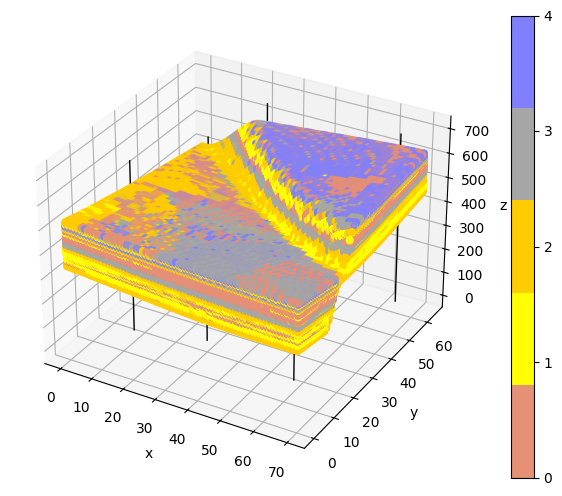

In [69]:
plot_3D_cube(data=facies_pred, color_map='facies', number_of_facies=4, number_of_wells=7)

              precision    recall  f1-score   support

         0.0       0.91      0.88      0.90    173009
         1.0       0.81      0.80      0.81    195124
         2.0       0.81      0.82      0.82    205246
         3.0       0.85      0.87      0.86    127077
         4.0       0.67      0.69      0.68     29677

    accuracy                           0.83    730133
   macro avg       0.81      0.81      0.81    730133
weighted avg       0.84      0.83      0.83    730133



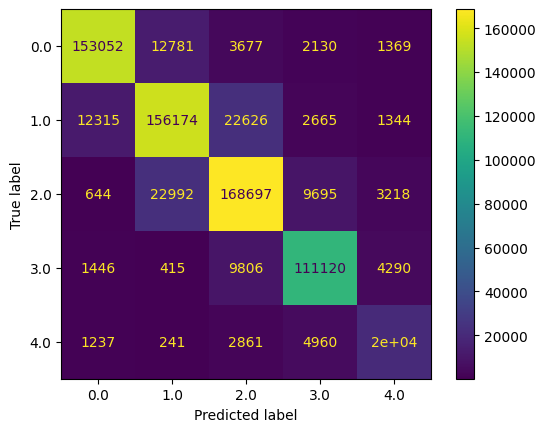

In [76]:
report_print_RF, f1_score_per_class_RF, count_facies, accuracy_test_RF = confusion_matrix_3D(facies_pred,
                                                                                                df_facies_comparison,
                                                                                                RF_Classifier_model)

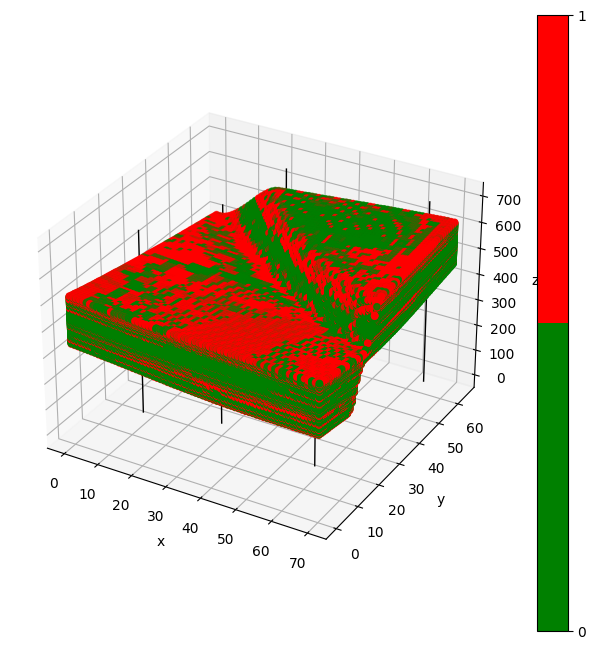

In [ ]:
difference_map_3D(df_facies_comparison, facies_pred, number_of_wells=7)

## Plot 2d section of the 3D cube

In [77]:
facies_pred_RF = facies_pred
facies_pred_RF.shape

(71, 65, 700)

In [78]:
df_facies_comparison_RF = df_facies_comparison
df_facies_comparison_RF.shape

(71, 65, 700)

In [79]:
facies_pred_RF[1].shape

(65, 700)

In [80]:
facies_pred_RF_2D = facies_pred_RF[35, :, :]
facies_pred_RF_2D.shape

(65, 700)

In [81]:
df_facies_comparison_RF_2D = df_facies_comparison_RF[35, :, :]
df_facies_comparison_RF_2D.shape

(65, 700)

In [82]:
extent_plot = [0, 65, 0, 700]

In [84]:
def difference_map(df_facies_comparison, facies_predicted, extent, list_of_wells=None):
    """ Function to plot difference map between the ground-truth and predicted facies.

    Args:
        df_facies_comparison (2D array): ground truth facies
        facies_predicted (2D array): predicted facies from ML models
        extent (list): List with depth and trace numbers for the plots
        list_of_wells (list): the list with wells location. Defaults to None.

    Returns:
        nothing

    """


    import matplotlib.pyplot as plt
    import matplotlib.colors

    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(1, 1, 1)

    extent = extent # define extent
    # The difference
    np_facies_fact = df_facies_comparison
    np_facies_predicted = facies_predicted

    facies_difference = np.subtract(np_facies_fact, np_facies_predicted)

    df1 = pd.DataFrame(facies_difference)
    df1 = df1.apply(np.sign).replace({-4:1, -3:1, -2:1, -1:1, 0:0,
                                1:1, 2:1, 3:1, 4:1
                                })
    facies_difference_result = np.array(df1)



    cmap = matplotlib.colors.ListedColormap(['green', 'red'])
    im = ax.imshow(facies_difference_result, cmap=cmap, vmin=0, vmax=1, aspect='auto', extent=extent)

    if list_of_wells==None:
        pass
    else:
        for well in list_of_wells:
            ax.axvline(x = well, linewidth = 1, color ='black')

    ax.set_xlabel('trace number', fontsize=14)
    ax.set_ylabel('TWT [ms]', fontsize=14)
    ax.set_title('Difference map', fontsize=16)
    colormap1 = fig.axes[0]
    colormap1.tick_params(labelsize=12)
    plt.colorbar(im, ticks=[True, False])
    plt.legend()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


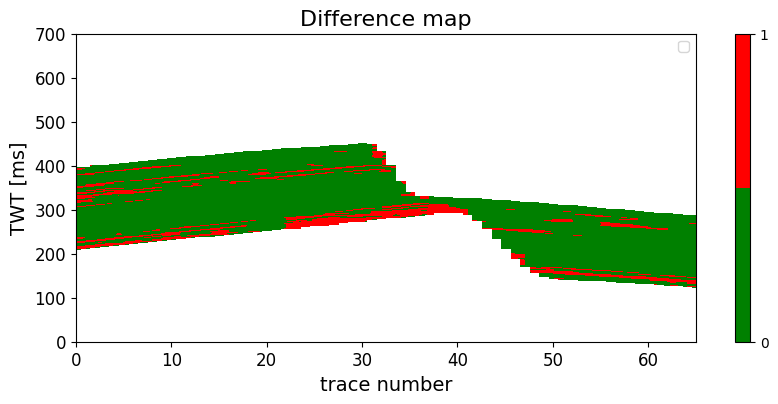

In [85]:
difference_map(df_facies_comparison_RF_2D.T, facies_pred_RF_2D.T, extent_plot, list_of_wells=None)

In [86]:
facies_pred_RF_2D_1 = facies_pred_RF[5, :, :]
facies_pred_RF_2D_1.shape

(65, 700)

In [87]:
df_facies_comparison_RF_2D_1 = df_facies_comparison_RF[5, :, :]
df_facies_comparison_RF_2D_1.shape

(65, 700)

In [88]:
extent_plot = [0, 65, 0, 700]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


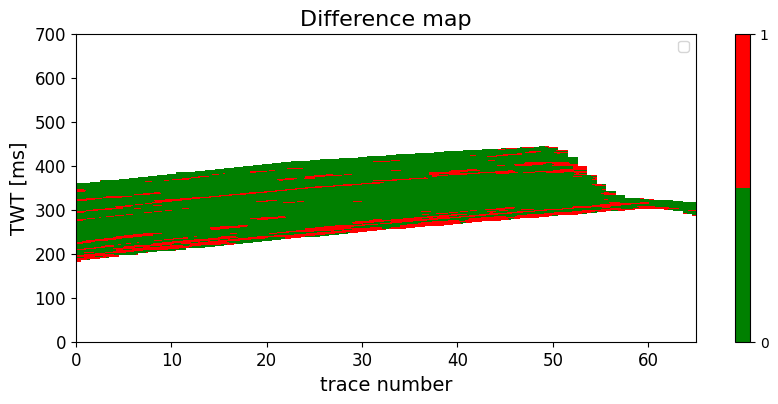

In [89]:
difference_map(df_facies_comparison_RF_2D_1.T, facies_pred_RF_2D_1.T, extent_plot, list_of_wells=None)

# Deep Learning model

In [92]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

2023-10-29 11:45:47.987300: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-29 11:45:48.025767: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-29 11:45:48.025801: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-29 11:45:48.025822: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-29 11:45:48.031663: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-29 11:45:48.032299: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense

In [94]:
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras import optimizers

In [95]:
from tensorflow.keras.layers import InputLayer

In [96]:
facies_and_features_NN = facies_and_features[['facies', 'relai', 'seis', 'envel', 'inst_freq', 'seis_inv']]
facies_and_features_NN

,facies,relai,seis,envel,inst_freq,seis_inv
296,2.0,0.706338,0.576049,-0.236991,-0.573114,0.375190
297,2.0,0.819881,0.403899,-0.283861,-0.635736,0.427023
298,2.0,0.884136,0.243593,-0.325186,-0.685833,0.473044
299,2.0,0.903801,0.095923,-0.355929,-0.700594,0.514216
300,2.0,0.879689,-0.050958,-0.387175,-0.676887,0.547856
...,...,...,...,...,...,...
422,1.0,0.535116,-1.042009,1.123232,-1.683755,1.262439
423,4.0,0.325316,-1.338140,1.062755,-1.233773,1.170338
424,4.0,0.019821,-1.648485,1.141375,-0.927821,1.030158
425,4.0,-0.372161,-1.921715,1.282488,-0.773951,0.830202


In [97]:
tf.random.set_seed(123)
tf.debugging.set_log_device_placement(False)

## Split the data in train, test and validation sets

In [98]:
facies_and_features_mixed = facies_and_features_NN.sample(frac=1) # shuffle the rows
facies_and_features_mixed.head(5)

,facies,relai,seis,envel,inst_freq,seis_inv
449,1.0,-1.174725,2.294398,2.143778,-0.686727,-0.355855
550,0.0,-2.153960,-0.993839,1.339437,-0.819575,-1.508114
326,1.0,0.432846,0.946410,-0.247071,-0.097636,-0.366381
407,0.0,0.201941,-0.420529,-0.781786,0.097833,-0.951762
517,0.0,-0.123406,0.332038,-0.969264,1.107384,-1.365429


In [99]:
train_set, test_val_set = train_test_split(facies_and_features_mixed, test_size=0.4)

print(train_set.shape)
print(test_val_set.shape)

(747, 6)
(498, 6)


In [100]:
train_set

,facies,relai,seis,envel,inst_freq,seis_inv
459,2.0,-0.567306,0.463125,-0.654785,-1.057538,-0.004916
485,3.0,1.950297,0.913244,0.286637,0.308063,1.374557
276,2.0,0.328009,-0.471069,-0.526272,-0.636183,0.372396
415,0.0,-1.799679,-0.064383,0.120830,-0.706856,-1.401818
303,2.0,0.536744,0.072232,-0.821096,0.285698,-0.284342
...,...,...,...,...,...,...
298,1.0,-0.566617,0.515244,-0.514176,-0.217065,-1.002271
416,2.0,0.470297,-0.384204,-0.512664,-0.809287,0.338273
348,3.0,0.931106,1.330196,0.602628,0.148378,0.847112
423,1.0,-0.530356,1.916930,1.500708,-0.980155,-0.378873


Split test_val_set on test and validation sets

In [102]:
test_set, val_set = train_test_split(test_val_set, test_size=0.5)
print(test_set.shape)
print(val_set.shape)

(249, 6)
(249, 6)


Plot the relationship between each two variables to spot anything incorrect.

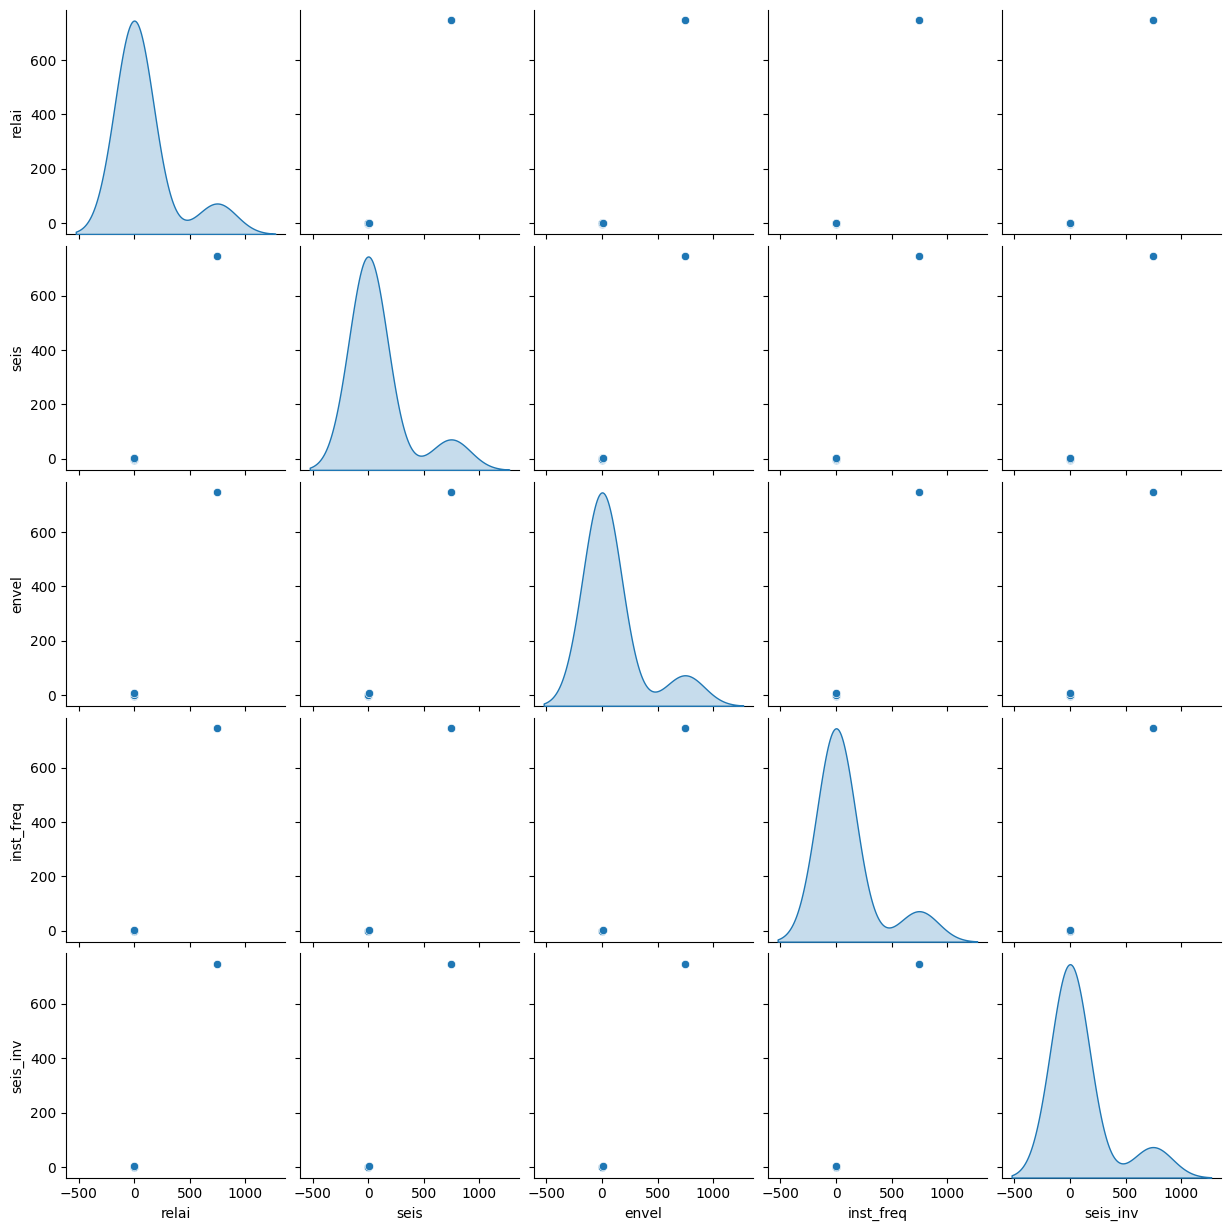

In [104]:
train_stats = train_set.describe()
train_stats.pop('facies')
sns.pairplot(train_stats[train_stats.columns], diag_kind="kde") # or diag_kind='reg'

Statistics on the train dataset to make sure it is in a good shape. (you may display the same stat for test and validate)

In [105]:
train_stats = train_set.describe()
train_stats.pop("facies")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
relai,747.0,-0.016129,1.023121,-2.153960,-0.659556,0.008924,0.625706,1.950297
seis,747.0,-0.011300,1.023850,-3.454488,-0.451327,0.043014,0.534196,3.248334
envel,747.0,0.049323,1.057228,-1.264592,-0.685275,-0.334762,0.579949,6.517257
inst_freq,747.0,-0.006547,0.998679,-2.563143,-0.532633,-0.053354,0.492350,3.789383
seis_inv,747.0,-0.010406,1.015546,-1.706998,-0.790105,-0.249355,0.510146,3.802520


Delete the facies column

In [106]:
train_labels1 = train_set.pop('facies')
test_labels1 = test_set.pop('facies')
valid_labels1 = val_set.pop('facies')

In [107]:
train_set

,relai,seis,envel,inst_freq,seis_inv
459,-0.567306,0.463125,-0.654785,-1.057538,-0.004916
485,1.950297,0.913244,0.286637,0.308063,1.374557
276,0.328009,-0.471069,-0.526272,-0.636183,0.372396
415,-1.799679,-0.064383,0.120830,-0.706856,-1.401818
303,0.536744,0.072232,-0.821096,0.285698,-0.284342
...,...,...,...,...,...
298,-0.566617,0.515244,-0.514176,-0.217065,-1.002271
416,0.470297,-0.384204,-0.512664,-0.809287,0.338273
348,0.931106,1.330196,0.602628,0.148378,0.847112
423,-0.530356,1.916930,1.500708,-0.980155,-0.378873


In [108]:
train_labels2 = train_labels1.astype(np.uint8)
train_labels2

valid_labels2 = valid_labels1.astype(np.uint8)
test_labels2 = test_labels1.astype(np.uint8)

Encode the labeles

In [109]:
train_labels = pd.get_dummies(train_labels1, prefix='Label')
val_labels = pd.get_dummies(valid_labels1, prefix='Label')
test_labels = pd.get_dummies(test_labels1, prefix='Label')

In [110]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 747 entries, 459 to 408
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Label_0.0  747 non-null    bool 
 1   Label_1.0  747 non-null    bool 
 2   Label_2.0  747 non-null    bool 
 3   Label_3.0  747 non-null    bool 
 4   Label_4.0  747 non-null    bool 
dtypes: bool(5)
memory usage: 9.5 KB


The data is already standartized

## Define the NN architecture

In [111]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Activation
from keras import optimizers, regularizers
from keras.callbacks import LearningRateScheduler
import math



def NN_model_advanced(train_set_shape):
    model = Sequential()

    # Input Layer
    model.add(Dense(128, input_shape=(train_set_shape,), kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.5))

    # Hidden Layer 1
    model.add(Dense(256, kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.5))

    # Hidden Layer 2
    model.add(Dense(128, kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.5))

    # Hidden Layer 3
    model.add(Dense(64, kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(5, activation='softmax'))

    optimizer = optimizers.Adamax(lr=0.0)  # initial learning rate will be set by LearningRateScheduler
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model





Epochs = 500
Batch_size = 150

model = NN_model_advanced(train_set.shape[1])
print('Here is a summary of this model: ')
model.summary()

with tf.device('/CPU:0'):
    history = model.fit(
        train_set,
        train_labels,
        batch_size=Batch_size,
        epochs=Epochs,
        verbose=1,
        shuffle=True,
        steps_per_epoch = int(train_set.shape[0]/Batch_size),
        validation_data = (val_set, val_labels))



Here is a summary of this model: 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               768       
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)     

In [112]:
print('summary of the results after each epoch: ')
hist_res = pd.DataFrame(history.history)
hist_res['epoch'] = history.epoch
hist_res.tail(10)

summary of the results after each epoch: 


,loss,accuracy,val_loss,val_accuracy,epoch
490,0.588239,0.853333,0.643459,0.795181,490
491,0.658878,0.827471,0.641233,0.791165,491
492,0.630770,0.842546,0.645363,0.783133,492
493,0.610876,0.830821,0.647493,0.791165,493
494,0.628909,0.824121,0.649076,0.791165,494
495,0.624946,0.826667,0.647299,0.795181,495
496,0.619833,0.834171,0.640806,0.795181,496
497,0.632235,0.834171,0.637199,0.791165,497
498,0.663895,0.819095,0.636707,0.799197,498
499,0.604978,0.844221,0.634216,0.803213,499


## Inspect the accuracy on the training set

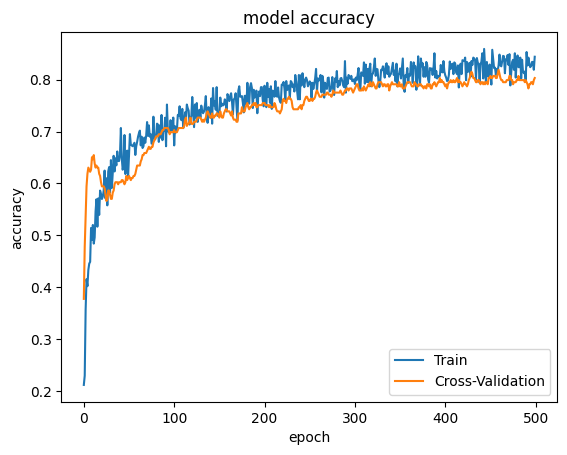

In [113]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Cross-Validation'], loc='lower right')
plt.show()

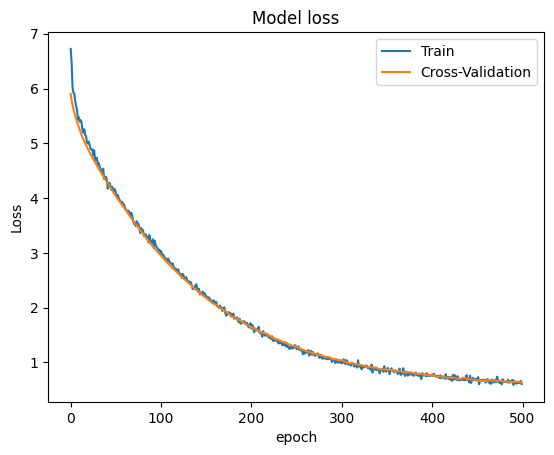

In [114]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Cross-Validation'], loc='upper right')
plt.show()

In [115]:
nn_test_prob = model.predict(test_set)
nn_test_prob.shape

8/8 [==============================] - 0s 1ms/step


(249, 5)

In [116]:
nn_test_prob

array([[9.9759728e-01, 2.0554881e-03, 5.4491297e-06, 3.3945355e-05,
        3.0787408e-04],
       [3.0802624e-04, 9.7813969e-03, 9.8481351e-01, 3.9718975e-03,
        1.1253225e-03],
       [5.4506748e-04, 6.0193785e-03, 1.4309442e-01, 8.1657618e-01,
        3.3764832e-02],
       ...,
       [1.0048165e-03, 5.9450918e-01, 3.9244014e-01, 1.1635530e-02,
        4.1022754e-04],
       [6.5267369e-02, 8.5734695e-01, 7.3631056e-02, 2.3577379e-03,
        1.3969281e-03],
       [4.1663642e-03, 3.3892694e-01, 3.3436081e-01, 3.1614003e-01,
        6.4058341e-03]], dtype=float32)

In [117]:
test_nn2 = np.array(pd.DataFrame(nn_test_prob).idxmax(axis=1))
test_nn2.shape

(249,)

In [118]:
dfg = test_nn2.reshape(test_nn2.shape[0], -1)

In [119]:
dfg.shape

(249, 1)

In [120]:
dfg

array([[0],
       [2],
       [3],
       [2],
       [0],
       [1],
       [3],
       [1],
       [2],
       [1],
       [2],
       [3],
       [0],
       [3],
       [3],
       [3],
       [2],
       [0],
       [0],
       [4],
       [3],
       [2],
       [3],
       [1],
       [1],
       [0],
       [2],
       [2],
       [1],
       [3],
       [2],
       [1],
       [2],
       [1],
       [0],
       [3],
       [1],
       [2],
       [1],
       [1],
       [0],
       [1],
       [3],
       [2],
       [4],
       [2],
       [0],
       [1],
       [2],
       [0],
       [4],
       [2],
       [2],
       [1],
       [2],
       [3],
       [3],
       [1],
       [1],
       [1],
       [3],
       [1],
       [1],
       [3],
       [4],
       [2],
       [2],
       [1],
       [0],
       [0],
       [4],
       [0],
       [1],
       [1],
       [0],
       [1],
       [3],
       [0],
       [0],
       [0],
       [3],
       [1],
       [1],
    

In [121]:
print(confusion_matrix(test_labels1, test_nn2))
print(accuracy_score(test_labels1, test_nn2))
print(classification_report(test_labels1, test_nn2))

[[45  2  3  0  2]
 [ 0 58  5  1  1]
 [ 0 15 46  2  0]
 [ 1  1  8 42  0]
 [ 0  0  0  3 14]]
0.8232931726907631
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92        52
         1.0       0.76      0.89      0.82        65
         2.0       0.74      0.73      0.74        63
         3.0       0.88      0.81      0.84        52
         4.0       0.82      0.82      0.82        17

    accuracy                           0.82       249
   macro avg       0.84      0.82      0.83       249
weighted avg       0.83      0.82      0.82       249



## Predict the facies section

In [122]:
def predict_facies_3D_NN(facies, relai_std, seis_std, envel_std, inst_freq_std, seis_inv_std, model):
    r, c, b = np.shape(facies)

    map_facies = np.zeros((r, c, b))
    map_facies[:] = np.NaN
    map_facies_1 = map_facies.copy()
    df_f_comparison = map_facies.copy()

    map_facies_encoded = np.zeros((b, 5))
    map_facies_encoded[:] = np.NaN
    facies_encoded = map_facies_encoded.copy()

    # for every trace (column)
    for every_x in range(facies.shape[0]):
        for every_y in range(facies.shape[1]):

            new_df = pd.concat(
                        [pd.DataFrame(relai_std[every_x, every_y]),
                        pd.DataFrame(seis_std[every_x, every_y]),
                        pd.DataFrame(envel_std[every_x, every_y]),
                        pd.DataFrame(inst_freq_std[every_x, every_y]),
                        pd.DataFrame(seis_inv_std[every_x, every_y])]
                        , axis=1)

    ##########################################################################
            new_features = new_df.dropna(axis=0)

            #new_features = new_df
            non_empty_facies = pd.DataFrame(facies[every_x, every_y, :]).dropna(axis=0)

            facies_encoded[new_features.index, :] = model.predict(new_features)
            facies_encoded_nn = np.array(pd.DataFrame(facies_encoded).idxmax(axis=1))
            facies_encoded_nn_1 = facies_encoded_nn.reshape(facies_encoded_nn.shape[0], -1)



            # map_facies[every_x, every_y, new_features.index] = model.predict(new_features)


            # Filter
            map_facies_1[every_x, every_y, non_empty_facies.index] = facies_encoded_nn[non_empty_facies.index]
            df_f_comparison[every_x, every_y, new_features.index] = facies[every_x, every_y, new_features.index]

    return map_facies_1, df_f_comparison

In [123]:
facies_pred, df_facies_comparison = predict_facies_3D_NN(facies, relai_std, seis_std, envel_std, inst_freq_std, seis_inv_std, model)

6/6 [==============================] - 0s 1ms/step


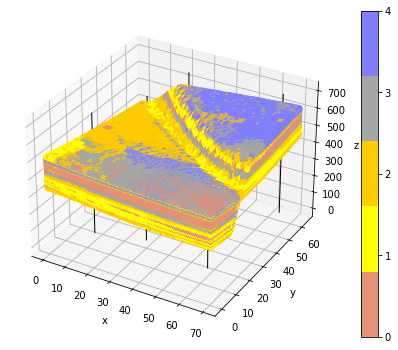

In [ ]:
plot_3D_cube(data=facies_pred, color_map='facies', number_of_facies=4, number_of_wells=7)

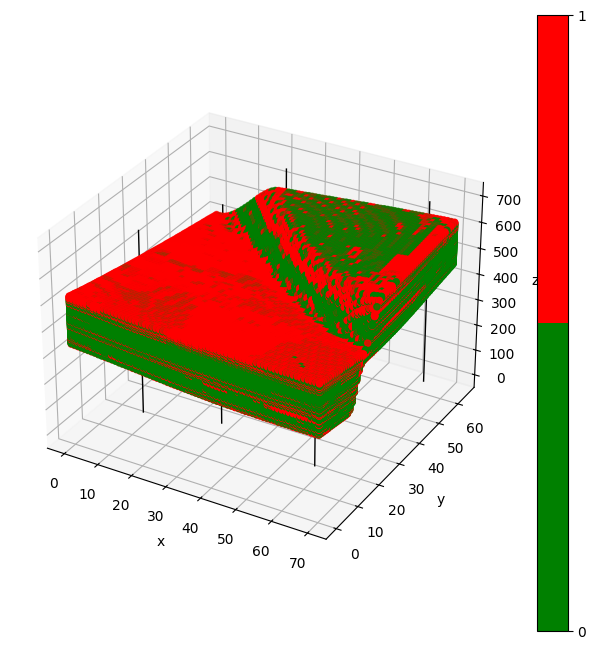

In [125]:
difference_map_3D(df_facies_comparison, facies_pred, number_of_wells=7)